# Logistic Regression with Principal Component Analysis

In [2]:
#Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [56]:
#Load the necessary data
fight_data = pd.read_csv("UFCData.csv")

In [57]:
fight_data.head()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,Red,True,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,...,0,0,1,0,0,0,0,1,0,0
1,Red,True,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,...,0,0,1,0,0,0,0,0,1,0
2,Red,False,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,...,0,0,1,0,0,0,0,1,0,0
3,Blue,False,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,...,0,0,0,0,0,1,0,1,0,0
4,Blue,False,3,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,...,0,0,0,0,1,0,0,0,1,0


In [58]:
#Trim any unnecessary columns that do not have any relevance to linear regression or will be hard to quantify
fight_data["Winner"] = (fight_data["Winner"]=="Red")*1
#Drop any columns that are not numeric values (e.g. City, Location)
drop_index = fight_data.dtypes.loc[fight_data.dtypes == object].index
fight_data.drop(drop_index, axis = 1, inplace = True)
#Drop any of the win by dummies as we will not know this information when making predictions
cleaned_fight_data = fight_data.drop(fight_data.filter(regex = "_win_by_").columns, axis = 1)

In [59]:
#Get rid of any NaN values for use in feature selection
cleaned_fight_data.fillna(value= 0, inplace = True)
cleaned_fight_data["title_bout"] *= 1
cleaned_fight_data.head()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,1,1,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,...,0,0,1,0,0,0,0,1,0,0
1,1,1,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,...,0,0,1,0,0,0,0,0,1,0
2,1,0,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,...,0,0,1,0,0,0,0,1,0,0
3,0,0,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,...,0,0,0,0,0,1,0,1,0,0
4,0,0,3,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,...,0,0,0,0,1,0,0,0,1,0


In [60]:
#Parse out X and y into training and test sets and normalize it for use in logistic regression
X = cleaned_fight_data.iloc[:,1:]
y = cleaned_fight_data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
#Fit PCA where n_components is equal to the number of features. This is going to be used for a visual exploration of the data
pca = PCA(n_components = len(X.columns))
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=147, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'cumulative explained variance')

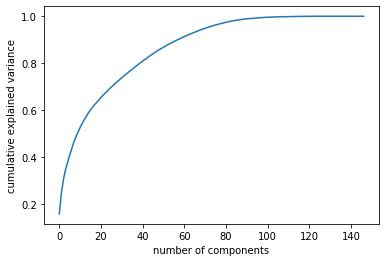

In [62]:
#Plot the cumulative variance to decide how many features should be included
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [63]:
#It appears as though there are 60 components that do not explain much of the variance at all. Therefore we are going to 
#transform the feature space to fit about 98% of the variance which should be about 80 components
pca_2 = PCA(.98)
pca_2.fit(X_train_scaled)
pca_2.n_components_

85

In [64]:
X_train_pca = pca_2.transform(X_train_scaled)
X_test_pca = pca_2.transform(X_test_scaled)
model = LogisticRegression(solver = "lbfgs", max_iter = 250)
model.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
model.score(X_test_pca, y_test)

0.6625835189309577

# Analysis
The model did not perform particularly well. It had a slight performace boost over just picking the favorite
but not by much. However, I think a much more meaningful measure is percentage landed, instead of the raw attempted
and landed so we are going to transform the original dataset and run it through the same sort of analysis. This will
also allow us to keep most of the data since it reduces the number of features and hopefully allow us to be more accurate.